In [1]:
pip install psycopg2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import psycopg2
import pandas as pd

***Access Historical Data***

In [6]:
# build connection to access the database -- access historical data
params = {
    "host": "host.docker.internal",
    "dbname": "airflow",
    "port": 5532,
    "user": "postgres",
    "password": "postgres"
}
connection = None

try:
    connection = psycopg2.connect(**params)
    print("Connected to the database successfully.")
except Exception as e:
    print(f"An error occurred while connecting to the database: {e}")

if connection:

    btcRealDf = pd.read_sql_query("SELECT * FROM Historical_Market_Price", connection)
    print(btcRealDf)

    connection.close()
else:
    print("Unable to create a DataFrame as the connection was not established.")


Connected to the database successfully.
        id   timestamp    values
0        1  1451606400    430.89
1        2  1451692800    434.75
2        3  1451779200    432.76
3        4  1451865600    430.78
4        5  1451952000    434.17
...    ...         ...       ...
2186  2187  1640476800  50470.89
2187  2188  1640563200  50801.11
2188  2189  1640649600  50692.30
2189  2190  1640736000  47601.26
2190  2191  1640822400  46408.87

[2191 rows x 3 columns]


***Access Real_Time Data***

In [27]:
# build connection to access the database -- access real-time data
params = {
    "host": "host.docker.internal",
    "dbname": "airflow",
    "port": 5532,
    "user": "postgres",
    "password": "postgres"
}
connection = None

try:
    connection = psycopg2.connect(**params)
    print("Connected to the database successfully.")
except Exception as e:
    print(f"An error occurred while connecting to the database: {e}")

if connection:

    btcRealDf = pd.read_sql_query("SELECT * FROM Real_Time_Market_Price", connection)
    print(btcRealDf)

    connection.close()
else:
    print("Unable to create a DataFrame as the connection was not established.")


Connected to the database successfully.
    id   timestamp    values
0    1  1681430400  30407.60
1    2  1681430400  30407.60
2    3  1681344000  29899.24
3    4  1681430400  30407.60
4    5  1681430400  30407.60
5    6  1681430400  30407.60
6    7  1681430400  30407.60
7    8  1681430400  30407.60
8    9  1681430400  30407.60
9   10  1681430400  30407.60
10  11  1681430400  30407.60
11  12  1681430400  30407.60
12  13  1681430400  30407.60
13  14  1681430400  30407.60
14  15  1681430400  30407.60
15  16  1681430400  30407.60
16  17  1681430400  30407.60
17  18  1681430400  30407.60
18  19  1681430400  30407.60
19  20  1681430400  30407.60
20  21  1681430400  30407.60
21  22  1681430400  30407.60
22  23  1681430400  30407.60
23  24  1681430400  30407.60
24  25  1681430400  30407.60
25  26  1681430400  30407.60
26  27  1681430400  30407.60
27  28  1681430400  30407.60
28  29  1681430400  30407.60
29  30  1681430400  30407.60
30  31  1681430400  30407.60
31  32  1681430400  30407.60
32 

# Imports

In [28]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.graph_objects as go
from sklearn.ensemble import IsolationForest
from datetime import datetime, timedelta,timezone

# Data preprocessing

In [30]:
#  convert timestamp to datetime
btcHistDf['Timestamp'] = pd.to_datetime(btcHistDf.timestamp, unit='s')
btcHistDf.head()

,id,timestamp,values,Timestamp
0,1,1451606400,430.89,2016-01-01
1,2,1451692800,434.75,2016-01-02
2,3,1451779200,432.76,2016-01-03
3,4,1451865600,430.78,2016-01-04
4,5,1451952000,434.17,2016-01-05


In [31]:
#  convert timestamp to datetime
btcRealDf['timestamp'] = pd.to_datetime(btcRealDf.timestamp, unit='s')
btcRealDf.head()

,id,timestamp,values
0,1,2023-04-14,30407.60
1,2,2023-04-14,30407.60
2,3,2023-04-13,29899.24
3,4,2023-04-14,30407.60
4,5,2023-04-14,30407.60


In [32]:
print('Days in Historical dataset: ',len(btcHistDf))

Days in Historical dataset:  2191


In [33]:
print('Days in Real-Time dataset: ',len(btcRealDf))

Days in Real-Time dataset:  56


In [36]:
# visualize the value as time series for historical data
histPano = btcHistDf.copy()
histPano = histPano.resample('D', on='Timestamp')[['values']].mean()
fig = go.Figure()
fig.add_trace(go.Scatter(x=histPano.index, y=histPano['values'],name='Full history BTC price'))
fig.update_layout(showlegend=True,title="BTC Historical Market Price",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()

In [37]:
# visualize the value as time series for real-time data
realPano = btcRealDf.copy()
realPano = realPano.resample('D', on='timestamp')[['values']].mean()
fig = go.Figure()
fig.add_trace(go.Scatter(x=realPano.index, y=realPano['values'],name='Full Real-Time BTC price'))
fig.update_layout(showlegend=True,title="BTC Real-Time Market Price",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()

# Data Anomalies

## Isolation forest model

In [39]:
# Preparing data to be passed to the Historical model
histOutliers = histPano.copy()
histOutliers.fillna(method ='bfill', inplace = True)

# Training the Historical model
hist_isolation_detector = IsolationForest(n_estimators=150,random_state=0,contamination='auto')
hist_isolation_detector.fit(histOutliers['values'].values.reshape(-1, 1))

IsolationForest(n_estimators=150, random_state=0)

In [40]:
# Preparing data to be passed to the Real-Time model
realOutliers = realPano.copy()
realOutliers.fillna(method ='bfill', inplace = True)

# Training the Real-Time model
real_isolation_detector = IsolationForest(n_estimators=150,random_state=0,contamination='auto')
real_isolation_detector.fit(realOutliers['values'].values.reshape(-1, 1))

IsolationForest(n_estimators=150, random_state=0)

In [42]:
# get the outliers from the historical data
hist_data_ready = np.linspace(histOutliers['values'].min(), histOutliers['values'].max(), len(histOutliers)).reshape(-1,1)
histOutlier = hist_isolation_detector.predict(hist_data_ready)

In [43]:
# get the outliers from the real-time data
real_data_ready = np.linspace(realOutliers['values'].min(), realOutliers['values'].max(), len(realOutliers)).reshape(-1,1)
realOutlier = real_isolation_detector.predict(real_data_ready)

In [44]:
# store the outliers in the historical datafram
histOutliers['outlier'] = histOutlier
histOutliers.head()

,values,outlier
Timestamp,,
2016-01-01,430.89,-1
2016-01-02,434.75,1
2016-01-03,432.76,1
2016-01-04,430.78,1
2016-01-05,434.17,1


In [45]:
# store the outliers in the real-time datafram
realOutliers['outlier'] = realOutlier
realOutliers.head()

,values,outlier
timestamp,,
2023-04-13,29899.24,-1
2023-04-14,30407.60,-1
2023-04-15,30486.05,1
2023-04-16,30319.32,1


## Plotting prices' anomalies

In [47]:
# visualize the outliers in the historical data
a = histOutliers.loc[histOutliers['outlier'] == 1] #anomaly
fig = go.Figure()
fig.add_trace(go.Scatter(x=histOutliers['values'].index, y=histOutliers['values'].values,mode='lines',name='BTC Price'))
fig.add_trace(go.Scatter(x=a.index, y=a['values'].values,mode='markers',name='Anomaly',marker_symbol='x',marker_size=2))
fig.update_layout(showlegend=True,title="BTC Historical Market Price anomalies - IsolationForest",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()

In [48]:
# visualize the outliers in the real-time data
a = realOutliers.loc[realOutliers['outlier'] == 1] #anomaly
fig = go.Figure()
fig.add_trace(go.Scatter(x=realOutliers['values'].index, y=realOutliers['values'].values,mode='lines',name='BTC Price'))
fig.add_trace(go.Scatter(x=a.index, y=a['values'].values,mode='markers',name='Anomaly',marker_symbol='x',marker_size=2))
fig.update_layout(showlegend=True,title="BTC Real-Time Market Price anomalies - IsolationForest",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()

# Data Analysis

In [51]:
histDataCheck = btcHistDf.groupby([btcHistDf['Timestamp'].dt.year])['values'].mean()
histDataCheck

Timestamp
2016      565.231721
2017     3936.087534
2018     7567.843562
2019     7363.272384
2020    11057.016421
2021    47386.446429
Name: values, dtype: float64

In [52]:
# get the mean of the real-time data by year
realDataCheck = btcRealDf.groupby([btcRealDf['timestamp'].dt.year])['values'].mean()
realDataCheck

timestamp
2023    30392.040893
Name: values, dtype: float64

<AxesSubplot:xlabel='Timestamp'>

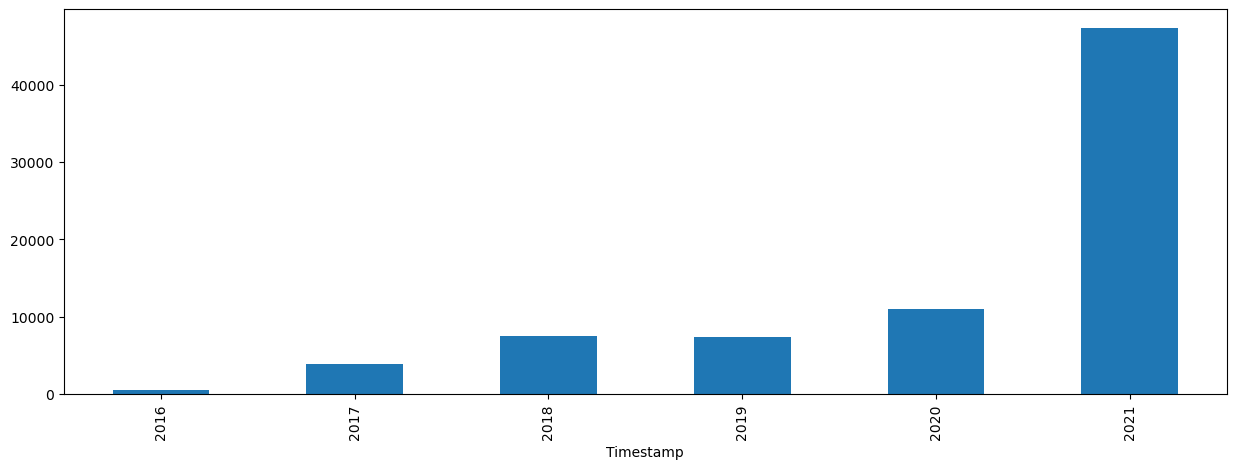

In [53]:
# visualize the mean of the historical data by year
f = plt.figure(figsize=(15,5))
ax = plt.gca()
histDataCheck.plot(ax=ax, kind='bar', figsize=(15,5))

<AxesSubplot:xlabel='timestamp'>

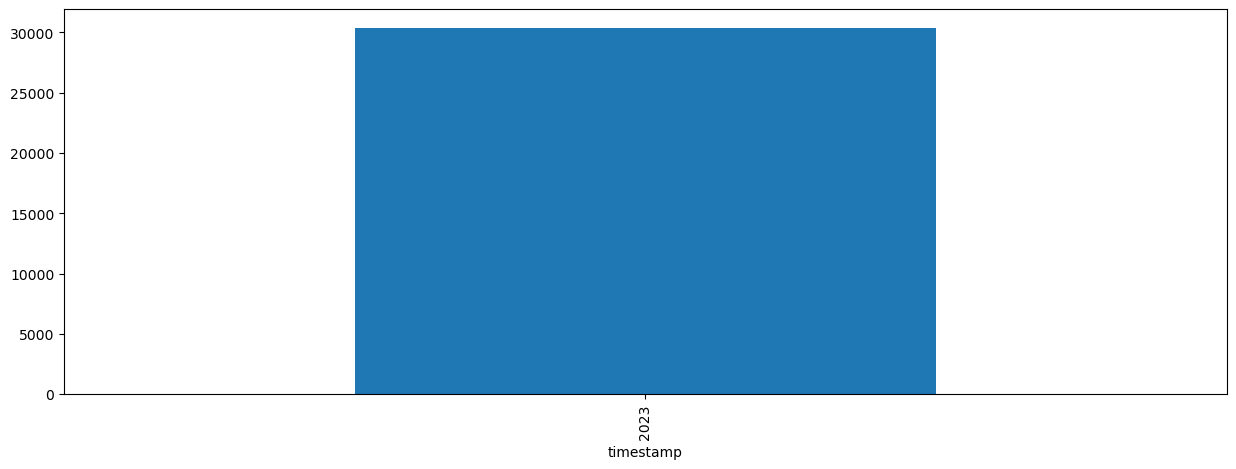

In [54]:
# visualize the mean of the real-time data by year
f = plt.figure(figsize=(15,5))
ax = plt.gca()
realDataCheck.plot(ax=ax, kind='bar', figsize=(15,5))